# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import matplotlib.pylab as pl
import math
import numpy as np
import numpy.linalg as nl
import scipy.spatial as ss
import scipy
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

from itertools import imap,combinations

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [2]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("a.bogovskij") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [4]:
matmul = lambda a, b: np.dot(np.atleast_2d(a), np.atleast_2d(b))
mT = lambda a: np.atleast_2d(a).transpose()

class GMMData:
    def __init__ (self, K, D):
        self.K, self.D = K, D
        self.mu = np.zeros(shape = (K, D), dtype=float)
        self.Sigma = np.zeros(shape = (K, D, D), dtype=float)
        self.Nk = np.zeros(shape=K, dtype=float)
        self.Distr = np.empty(shape=K, dtype=type(scipy.stats.multivariate_normal()))
        
    def KMeans2GMM(self, X, mu):
        K, D = self.K, self.D
        if X.shape[1] != D or mu.shape != (K, D):
            raise AttributeError
        self.Nk = np.zeros(shape = K, dtype=float)
        
        # init nk, mu, sigma from given means
        for x in X:
            c = np.argmin(np.fromiter((nl.norm(x - mu_i) for mu_i in mu), dtype=float))
            self.Nk[c] += 1
            self.mu[c] += x
            self.Sigma[c] += matmul(mT(x - mu[c]), x - mu[c])
        for c in xrange(K):
            self.mu[c] /= self.Nk[c] 
            self.Sigma[c] /= self.Nk[c]
           
        # if Sigma[k] is singular replace it
        for c in xrange(K):
            if not nl.cond(self.Sigma[c]) < 1 / sys.float_info.epsilon:
                scale = 1.0 / (D * self.Nk[c]) * sum(nl.norm(x - self.mu[c]) for x in X)
                self.Sigma[c] = scale * np.identity(D)
        self.BuildDistr()
                
    def BuildDistr(self):
        for k in xrange(self.K):
            self.Distr[k] = scipy.stats.multivariate_normal(mean = self.mu[k], cov = self.Sigma[k])
                
    def PDF(self, x, k):
        if self.K <= k:
            print "PDF k is out of bound"
            raise
        return self.Distr[k].pdf(x)
        
    def _print(self):
        print 'k: {}'.format(k)
        print 'Sigma: {}'.format(self.Sigma)
        print 'Mean: {}'.format(self.mu)
        print 'Nk {}'.format(self.Nk)
            

class Clustering:
    """
    Gaussian Mixture Model (using max a-posteriori)
    """
    
    default_K = 8
    conv_mu = 1E-2
    conv_Sigma = 1E-2
    
    def __init__(self, **kwargs):
        if len(kwargs) > 1:
            raise AttributeError('extra kwargs')
        self.K = kwargs['k'] if 'k' in kwargs else Clustering.default_K
        return
    
    def fit(self, X, Y=None):
        """
        Use data matrix x to compute model parameters
        """
        if Y is not None:
            raise NotImplementedError 
        (N, D), K = X.shape, self.K
       
        p, q = GMMData(K, D), GMMData(K, D)
        gamma = np.zeros(shape = (N, K), dtype = float)
        
        ####################################
        # init GMM: K-Means++ init
        ####################################
        means = sc.KMeans(K).fit(X).cluster_centers_ # good for any dataset w/out noise
        # NOTE: For noisy data consider using Adaptive(alpha = 0.5) from arxiv.org/abs/1312.5946     
        
        '''
        # Initialization by KMeans(k=2) results in convergence on 1st iter
        # To ensure GMM works correctly you can vary initial "means" manually
        means = np.array([[5.,5.,5.,5.,],[-3.,-3.,-3.,-3.]]) 
        '''
        
        p.KMeans2GMM(X, means)
        
        #####################################
        # converge GMM
        #####################################
        
        L = -inf
        converged = False
        #nan_cnt = 0
        iter_cnt = 0
        while not converged:
            p, q = q, p
            iter_cnt += 1
            
            # expectation
            for (n, k), v in np.ndenumerate(gamma):
                try:
                    gamma[n, k] = q.Nk[k] * q.PDF(X[n], k) / sum([q.Nk[j] * q.PDF(X[n], j) for j in xrange(K)])
                    if np.isnan(gamma[n, k]):
                        #print '[WRN] Gamma[n={}, k={}] = nan. Skiping it as noise.'.format(n, k)
                        #nan_cnt += 1
                        gamma[n, k] = 0.0
                except:
                    print 'Gamma[{},{}] for x[n] = {} failed'.format(n, k, X[n])
                    raise

            # maximization
            for k in xrange(K):
                p.Nk[k] = gamma[:,k].sum()
                p.mu[k] = sum(gamma[n,k] * X[n] for n in xrange(N)) /  p.Nk[k]
                p.Sigma[k] = sum(gamma[n,k] * matmul(mT(X[n] - p.mu[k]), X[n] - p.mu[k]) for n in xrange(N)) / p.Nk[k]
            p.BuildDistr()
            
            # check convergence
            converged = nl.norm(p.mu - q.mu) < self.conv_mu and nl.norm(p.Sigma - q.Sigma) < self.conv_Sigma            

            # assert likelyhood
            old_L = L
            try:
                L = np.fromiter((np.log(np.fromiter((1.0 * p.Nk[k] / N * p.PDF(X[n], k) for k in xrange(K)),
                    dtype = float)).sum() for n in xrange(N)), dtype = float).sum()
            except:
                print 'Likelyhood calculation failed'
                raise

            if old_L > L:
                raise Exception("Likelyhood was REDUCED on maximization step.")
        print iter_cnt
        self.model = p
        return self
    
    
    def predict(self, X):
        """
        Using fitted GMM parameters predict cluster for objects from x
        """
        m = self.model
        K = self.K
        
        if X.shape[1] != m.D:
            raise AttributeError
        
        gamma = lambda n, k: m.Nk[k] * m.PDF(X[n], k) / sum([m.Nk[j] * m.PDF(X[n], j) for j in xrange(K)])
        getcluster = lambda n: np.argmax(np.fromiter((gamma(n, k) for k in xrange(K)), dtype=float))
        return np.fromiter((getcluster(n) for n in xrange(len(X))), dtype=int)
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

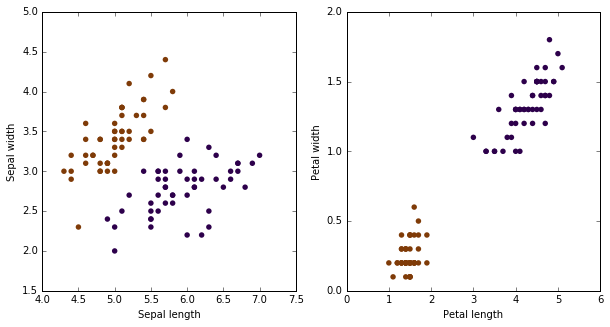

In [5]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [6]:
pred_iris = Clustering(k = 2).fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

1
Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Silhouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [11]:
def get_centroid(x, y, k):
    mean = np.zeros(shape = x.shape[1], dtype = float)
    cnt = 0
    for i in xrange(len(x)):
        if y[i] == k:
            cnt += 1
            mean += x[i]
    return mean

def quality_inert(x, y):
    K = np.max(y) + 1
    centr = np.zeros(shape=(K, x.shape[1]), dtype = float)
    for k in xrange(K):
        centr[k] = get_centroid(x, y, k)
    return sum(nl.norm(x[i] - centr[y[i]]) for i in xrange(len(x)))

def quality_radius(x, y):
    K = np.max(y) + 1
    centr = np.zeros(shape=(K, x.shape[1]), dtype = float)
    r = 0.0
    for k in xrange(K):
        centr[k] = get_centroid(x, y, k)
        r += max(nl.norm(x[i] - centr[y[i]]) for i in xrange(len(x)) if y[i] == k)
    return r / K

def quality_silhouette(x, y):
    return smt.silhouette_score(x, y)
    
def quality(x, y):
    return quality_silhouette(x, y)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

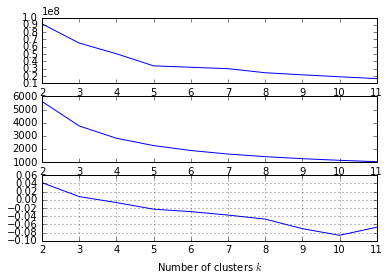

In [17]:
ks = range(2, 12)
#criteria = np.zeros(len(ks))
'''
qinert = np.zeros(len(ks))
qradius = np.zeros(len(ks))
qsilh = np.zeros(len(ks))

for i, k in enumerate(ks):
    print k,
    cls = Clustering(k = k)
    y = cls.fit_predict(x)
    #criteria[i] = quality(x, y)
    qinert[i] = quality_inert(x, y)
    qradius[i] = quality_radius(x, y)
    qsilh[i] = quality_silhouette(x, y)
'''
f, (ax1, ax2, ax3) = plt.subplots(3)
#pl.plot(ks, qradius)
ax1.plot(ks, qinert)
ax2.plot(ks, qradius)
ax3.plot(ks, qsilh)

pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [20]:
cls = Clustering(k = 2)
y = cls.fit_predict(x)

5


Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 11434
[t-SNE] Computed conditional probabilities for sample 2000 / 11434
[t-SNE] Computed conditional probabilities for sample 3000 / 11434
[t-SNE] Computed conditional probabilities for sample 4000 / 11434
[t-SNE] Computed conditional probabilities for sample 5000 / 11434
[t-SNE] Computed conditional probabilities for sample 6000 / 11434
[t-SNE] Computed conditional probabilities for sample 7000 / 11434
[t-SNE] Computed conditional probabilities for sample 8000 / 11434
[t-SNE] Computed conditional probabilities for sample 9000 / 11434
[t-SNE] Computed conditional probabilities for sample 10000 / 11434
[t-SNE] Computed conditional probabilities for sample 11000 / 11434
[t-SNE] Computed conditional probabilities for sample 11434 / 11434
[t-SNE] Mean sigma: 0.060719
[t-SNE] Error after 100 iterations with early exaggeration: 1.419814
[t-SNE] Error

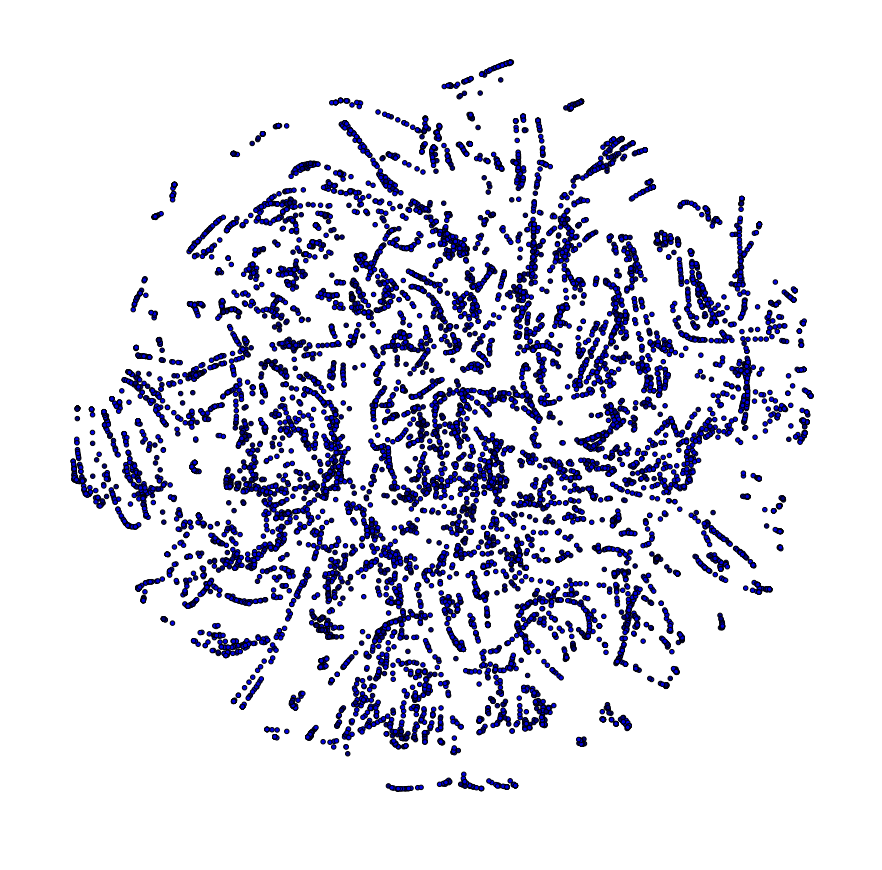

In [21]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

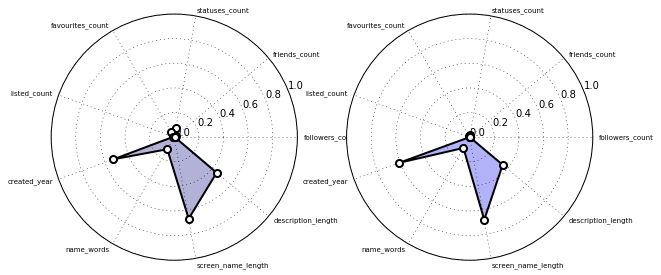

In [22]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.